In [0]:
# Peter Karras 2020
''' Contains the Custom Dataset creation and the CNN
    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'''

' Contains the Custom Dataset creation and the CNN\n    NOTE: MUST HAVE FILE FROM MAKEMASTER PROGRAM PRIOR TO RUNNING'

In [0]:
""" IMPORT NEEDED MODULES """

import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets


In [2]:
# Mounts Google drive to runtime instance, basically makes it so you can access 
# drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
""" CREATE CUSTOM DATASET """

class BCIDataset2(Dataset):
    def __init__(self, csv_master_path, transform=None):
        """
        Args:
            csv_master_path (string): path to csv file with thermal image (csv's) file paths
            as first column and GPP values as the second column, rows are one set of
            correlating data points
            transform (callable, optional): Optional transform to be applied on a sample
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file 
        #self.data_info = pd.read_csv(csv_master_path, header=None)
        self.data_info = pd.read_csv(csv_master_path)
        # First column contains thermal image (csv's) file paths
        self.thermal_path_arr = np.asarray(self.data_info.iloc[:,0])
        # Second column is the GPP values for the images from first column
        self.GPP_arr = np.asarray(self.data_info.iloc[:,1])
        
        #tempGPP_arr = np.asarray(self.data_info.iloc[:,1])
        # CASTING GPP TO INT, to mimic "buckets" all 24.XXX values go into 24 bucket etc.
        #self.GPP_arr = self.GPP_arr.astype(np.int_)
        
        self.transform = transforms.ToTensor()#transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5))])
        
        # Not to be done here? In __init__?
        # Calculate length of file batch by calculating len of master file
        #self.data_len = len(self.data_info)
        
        
    #NOTE: might need to flip image
    def __getitem__(self, index):
        # Get thermal image (csv) path
        single_thermal_path = self.thermal_path_arr[index]
        # Convert csv to pandas dataframe
        pd_thermal_img = pd.read_csv(single_thermal_path)
        # Convert pandas dataframe to numpy array
        ###np_thermal_img = np.asarray(pd_thermal_img.iloc[:,1:])
        np_thermal_img = np.asarray(pd_thermal_img)
        # Standardization of values from orignal csv file in order to properly
        # process image, first translates thermal values to 0-1 range, then 
        # multiply by 255 to enable processing by PIL Image library
        max_val = np.amax(np_thermal_img)
        min_val = np.amin(np_thermal_img)
        np_thermal_img = ((np_thermal_img-min_val)/(max_val - min_val)) * 255
        # Flip image by 90 degrees, is commented out currently as might mess with network architecture
        #np_thermal_img = np.rot90(np_thermal_img)
        # Creation of image, conversion to grayscale
        thermal_img = Image.fromarray(np_thermal_img)
        thermal_img = thermal_img.convert('L')
        # Transform image to tensor
        tensor_thermal_img = self.to_tensor(thermal_img)
        # Get GPP value for image
        single_image_GPP = self.GPP_arr[index]
        # Apply transform to image if present
        #if self.transform:
            #tensor_thermal_img = self.transform(tensor_thermal_img)
        #sample = {'image': tensor_thermal_img, 'GPPVal': single_image_GPP}
        #return sample
        #Return thermal image as tensor and GPP label
        return(tensor_thermal_img, single_image_GPP)
    
    def __len__(self):
        return len(self.data_info)

In [0]:
""" LOAD IN DATA """

# Number of subprocesses to use for data loading 
# Note: Currently unused but can be altered in future
num_workers = 0
# How many samples per batch to load
batch_size = 3
# Proportion of training set to use for validation and testing
# Note: this will be split in equal halves, one for validation, one for testing
valid_and_test_proportion = 0.3


# Define transforms
transformations = transforms.Compose([transforms.ToTensor()])
# Define custom datasets, for training and for testing
# Note: Will be using 10,000 data for testing, 50,000 data for training in future
masterfileMLLocation = r"drive/My Drive/BCIMLR/csvdata/populatedGPPs.csv"
BCIDataset = BCIDataset2(masterfileMLLocation)

# Obtain indices for training, validation and testing datasets
num_train = len(BCIDataset)         # Number of data points (csv files to be used)
indices1 = list(range(num_train))   # indices of [0,num_train) to represent data
np.random.shuffle(indices1)         # Shuffled indices
# Splitting training from validation/testing
split1 = int(np.floor(valid_and_test_proportion * num_train))

train_indices, valid_and_test_indices = indices1[split1:], indices1[:split1]
# Splitting validation/testing up into their individual groups
num_valid_test = len(valid_and_test_indices)
split2 = int(np.floor(0.5 * num_valid_test))
valid_indices, test_indices = valid_and_test_indices[split2:], valid_and_test_indices[:split2]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Prepare data loaders 
train_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(BCIDataset, batch_size=batch_size,
                                           sampler=test_sampler, num_workers=num_workers)



# Specify the image classes, GPP values of 1-35, can be split up into more classes, but is as such 
# for current testing purposes. Goal of possibly moving to ~100 classes with decimal values, possibly looking
# at only daytime values and shortening the range of GPP values to allow for more significant figures.
#classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
           #'19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']

tensor(4.5640, dtype=torch.float64)
tensor(4)
(1, 320, 240)
tensor(0., dtype=torch.float64)
tensor(0)
(1, 320, 240)
tensor(0., dtype=torch.float64)
tensor(0)
(1, 320, 240)


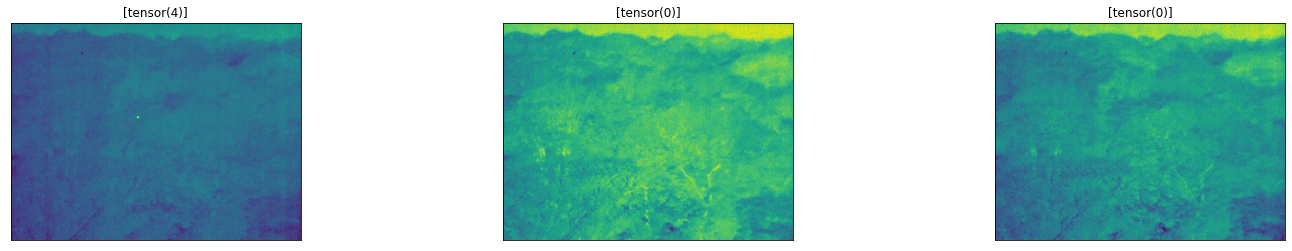

In [5]:
""" VISUALIZE A BATCH OF THE DATA """

csvfilesMLLocation = r"drive/My Drive/BCIMLR/csvdata"
os.chdir(csvfilesMLLocation)
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.imshow(np.rot90(np.squeeze(img)))
    
# Obtain one batch of training images
dataiter = iter(train_loader)
type(dataiter)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

    # print(images[1].shape)
    # imgtoshow = Image.fromarray(images[1], 'L')
    # imgtoshow.show()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 3 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    print(labels[idx])
    print(labels[idx].long())
    ax.set_title([labels[idx].long()])
    # Save Images for inspection
    print(images[idx].shape)

In [0]:
class BCIModel(nn.Module):
    def __init__(self):
        super(BCIModel, self).__init__()
        # Convulutional Layer 1 (sees 320 x 240 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding = 1)
        # Convulutional Layer 2 (sees 160 x 120 x 16 tensor, reduced height and width from max pooling layer)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # Convulutional Layer 3 (sees 80 x 60 x 32 tensor, reduced height and width from max pooling layer)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # Convulutional Layer 4 (sees 40 x 30 x 64 tensor, reduced height and width from max pooling layer)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        # Linear layer 1 (128 * 20 * 15 -> 100)
        self.fc1 = nn.Linear(128 * 20 * 15, 100)
        # Linear layer 2 (100 -> 35)
        # Note: Produces 35 class scores, buckets for each GPP 
        self.fc2 = nn.Linear(100, 1)
        # Dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Add sequence of convulutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # Flatten image input
        x = x.view(-1, 128 * 20 * 15)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        return x

In [12]:
# Defining the model
model = BCIModel()
# defining the optimizer
optimizer = optim.SGD(model.parameters(), lr =0.01)
# defining loss function
criterion = nn.MSELoss()
print(model)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

BCIModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=38400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
CUDA is available!  Training on GPU ...


In [16]:
""" TRAINING OF MODEL """
if train_on_gpu:
  print("yes")
# Number of epochs to train the model
# try 10, 100, 500, 1000
n_epochs = 5

valid_loss_min = np.Inf    # Track change in validation loss, set 

for epoch in range(1, n_epochs+1):
    print("Epoch #:", epoch)
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # Clear the gradients fo all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Fixes shape
        output = torch.flatten(output)
        #print(output)
        #print("Shape of output: ", output.shape)
        #print(target)
        #print("Shape of target: ", target.shape)
        
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data, target = data.float(), target.float()
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = torch.flatten(output)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # Calculate avearage losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Print training/validation stats
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_BCI.pt')
        valid_loss_min = valid_loss
        
print("Operation Complete")

yes
Epoch #: 1
Epoch: 1 	Training Loss: 110.235491 	Validation Loss: 111.572929
Validation loss decreased (inf --> 111.572929).  Saving model ...
Epoch #: 2
Epoch: 2 	Training Loss: 110.235491 	Validation Loss: 111.572930
Epoch #: 3
Epoch: 3 	Training Loss: 110.235491 	Validation Loss: 111.572928
Validation loss decreased (111.572929 --> 111.572928).  Saving model ...
Epoch #: 4
Epoch: 4 	Training Loss: 110.235491 	Validation Loss: 111.572928
Validation loss decreased (111.572928 --> 111.572928).  Saving model ...
Epoch #: 5
Epoch: 5 	Training Loss: 110.235491 	Validation Loss: 111.572929
Operation Complete


In [0]:
""" TESTING OF MODEL """

# Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(35))
class_total = list(0. for i in range(35))

# Puts model will notify all your layers that you are in eval mode, that way, 
# batchnorm or dropout layers will work in eval mode instead of training mode.
model.eval()

# for data, target in test_loader:
#     print(data)
#     print(target)
    
# Iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update test loss 
        test_loss += loss.item()*data.size(0)
        # Convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # Compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        # Calculate test accuracy for each object class
#         for i in range(batch_size):
#             label = target.data[i]
#             class_correct[label] += correct[i].item()
#             class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

C:\Users\Peter\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 18.282292

